In [36]:
from catboost import CatBoostClassifier
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook

from sklearn.neighbors import BallTree
import lightgbm as lgb

# load data

In [37]:
X = pd.read_csv('data_csv/X_train.csv')
y = pd.read_csv('data_csv/y_train.csv')
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=.3, random_state=22, shuffle=False)

X_result = pd.read_csv('data_csv/X_test.csv')
y_result = pd.read_csv('data_csv/y_test.csv')

In [38]:
X_train.head()

,TX,TY,X,Y,Z,chisquare,ele_P,event_id,brick
0,-0.246354,0.537723,39374.980469,70914.062500,10344.0,NaN,NaN,-999,0
1,0.273624,-0.079167,33111.000000,29527.986328,53013.0,NaN,NaN,-999,0
2,0.078478,-0.190802,50402.960938,13325.749023,7758.0,NaN,NaN,-999,0
3,-0.010640,0.626656,66492.312500,13776.416016,11637.0,NaN,NaN,-999,0
4,-0.375354,-0.043933,45265.507967,11006.269019,46548.0,0.864314,NaN,179162,0


# check data distributions

In [39]:
data = pd.concat([X_train, y_train], axis=1)

In [40]:
data = data.loc[data.brick==0]
data.head(4)

,TX,TY,X,Y,Z,chisquare,ele_P,event_id,brick,signal
0,-0.246354,0.537723,39374.980469,70914.062500,10344.0,NaN,NaN,-999,0,0
1,0.273624,-0.079167,33111.000000,29527.986328,53013.0,NaN,NaN,-999,0,0
2,0.078478,-0.190802,50402.960938,13325.749023,7758.0,NaN,NaN,-999,0,0
3,-0.010640,0.626656,66492.312500,13776.416016,11637.0,NaN,NaN,-999,0,0


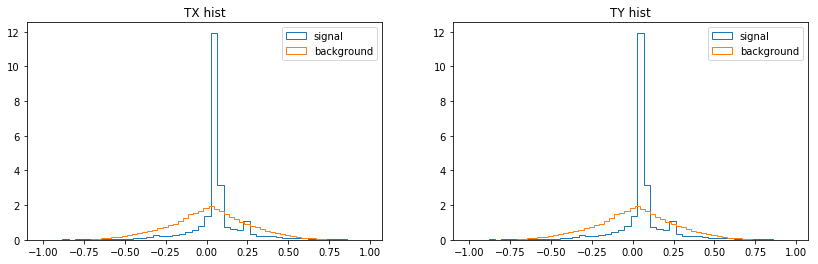

In [41]:
def draw_tan(data):
    plt.figure(figsize=(14, 4))
    for i, axis in zip([1, 2], ['TX','TY']):
        plt.subplot(1, 2, i)
        plt.hist(data[data.signal == True]['TY'].dropna(), bins=50, histtype="step", normed=True)
        plt.hist(data[data.signal == False]['TY'].dropna(), bins=50, histtype="step", normed=True)
        plt.title(axis + ' hist')
        plt.legend(['signal','background'])
    plt.show()

draw_tan(data)

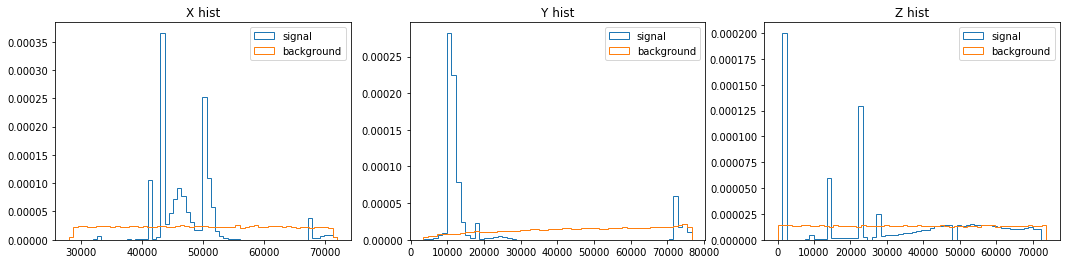

In [42]:
def draw_axes(data):
    plt.figure(figsize=(18, 4))
    for i, axis in zip([1, 2, 3], ['X','Y','Z']):
        plt.subplot(1, 3, i)
        plt.hist(data[data.signal == True][axis], bins=58, histtype="step", normed=True)
        plt.hist(data[data.signal == False][axis], bins=58, histtype="step", normed=True)
        plt.title(axis + ' hist')
        plt.legend(['signal','background'])
    plt.show()
    
draw_axes(data)

## features

In [43]:
from sklearn.neighbors import BallTree
from tqdm import tqdm

In [44]:
def generate_pairs(df, metric):
    """
    1. in one brick find neighboring tracks by Z coordinate
    2. using BallTree for get indices of 3 closest neighbors (minkowski metric)
    """
    dist = 1293.0
    pairs = []
    for brick in tqdm(df.brick.unique()):
        ind = df[df.brick == brick]
        z_values = list(sorted(ind.Z.unique()))
        
        for z, z_next in zip(z_values, z_values[1:]):
            z = ind[ind.Z == z].copy()
            z_next = ind[ind.Z == z_next].copy()
            z[['TX', 'TY']] *= dist
            z_next[['TX', 'TY']] *= dist
            
            
            columns = ['TX', 'TY', 'X', 'Y', 'Z']
            cols_without_Z = columns[:-1]
            bt = BallTree(z_next[cols_without_Z], metric=metric)
            d, i = bt.query(z[cols_without_Z])
            data = z_next.iloc[i[:, 0]]
            
            for col in columns:
                z[col + '_pair'] = data[col].values
            if 'event_id' in data.columns:
                z['same_pair'] = data.event_id.values == z.event_id.values
            pairs.append(z)
            
        pairs.append(z_next)
        
    pairs = pd.concat(pairs)
    for col in columns:
        pairs['d' + col] = pairs[col].values - pairs[col + '_pair'].values
    return pairs

# training

In [45]:
train_pairs = generate_pairs(X_train, 'minkowski')
train_pairs.head()

100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


,TX,TX_pair,TY,TY_pair,X,X_pair,Y,Y_pair,Z,Z_pair,brick,chisquare,ele_P,event_id,same_pair,dTX,dTY,dX,dY,dZ
59,-350.884986,209.727688,719.712283,175.767184,40312.250000,40952.589844,51044.425781,51001.667969,0.0,1293.0,0,NaN,NaN,-999,True,-560.612673,543.945099,-640.339844,42.757812,-1293.0
147,-492.330906,363.848652,-268.412944,354.829406,69648.484375,68919.906250,36894.371094,36682.976562,0.0,1293.0,0,NaN,NaN,-999,True,-856.179558,-623.242349,728.578125,211.394531,-1293.0
162,368.923479,94.810382,223.821761,-69.051396,65254.820312,64489.574219,51505.593750,50865.937500,0.0,1293.0,0,NaN,NaN,-999,True,274.113097,292.873157,765.246094,639.656250,-1293.0
185,-362.405577,-274.377684,159.111632,133.003909,33345.265625,32702.113281,24571.187500,25368.353516,0.0,1293.0,0,NaN,NaN,-999,True,-88.027894,26.107723,643.152344,-797.166016,-1293.0
216,151.571538,329.623590,-549.452840,-24.917188,48744.027344,50734.101562,47309.460938,45690.906250,0.0,1293.0,0,NaN,NaN,-999,True,-178.052052,-524.535653,-1990.074219,1618.554688,-1293.0


In [46]:
X_train_data = train_pairs[train_pairs.same_pair.notnull()]
y_train_data = X_train_data['same_pair'].astype(int)
X_train_data = X_train_data.drop(['event_id',  'same_pair'], axis=1)
X_train_data.head()

,TX,TX_pair,TY,TY_pair,X,X_pair,Y,Y_pair,Z,Z_pair,brick,chisquare,ele_P,dTX,dTY,dX,dY,dZ
59,-350.884986,209.727688,719.712283,175.767184,40312.250000,40952.589844,51044.425781,51001.667969,0.0,1293.0,0,NaN,NaN,-560.612673,543.945099,-640.339844,42.757812,-1293.0
147,-492.330906,363.848652,-268.412944,354.829406,69648.484375,68919.906250,36894.371094,36682.976562,0.0,1293.0,0,NaN,NaN,-856.179558,-623.242349,728.578125,211.394531,-1293.0
162,368.923479,94.810382,223.821761,-69.051396,65254.820312,64489.574219,51505.593750,50865.937500,0.0,1293.0,0,NaN,NaN,274.113097,292.873157,765.246094,639.656250,-1293.0
185,-362.405577,-274.377684,159.111632,133.003909,33345.265625,32702.113281,24571.187500,25368.353516,0.0,1293.0,0,NaN,NaN,-88.027894,26.107723,643.152344,-797.166016,-1293.0
216,151.571538,329.623590,-549.452840,-24.917188,48744.027344,50734.101562,47309.460938,45690.906250,0.0,1293.0,0,NaN,NaN,-178.052052,-524.535653,-1990.074219,1618.554688,-1293.0


In [47]:
lgb_train = lgb.Dataset(X_train_data, y_train_data)
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'max_depth': 15,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 4
}

num_round = 20
lgb.cv(params, lgb_train, num_round, nfold=5)

num_round = 100
bst = lgb.train(params, lgb_train, num_round)

In [54]:
X_test_data = generate_pairs(X_test, 'minkowski')
X_test_data.head()

100%|██████████| 3/3 [00:01<00:00,  1.57it/s]


In [49]:
y_pred = bst.predict(X_test_data.drop(['same_pair', 'chisquare', 'ele_P'], axis=1).reset_index(drop=True))

raw = pd.DataFrame({'id': test_pairs.index, 'prob': y_pred}).groupby('id')
agg = raw.aggregate(('mean', 'max', 'min'))['prob']

answer = pd.DataFrame(data={'id': agg.index, 'signal': agg['mean'].values})
answer.head()

,id,signal
0,290524,0.704411
1,290525,0.134418
2,290526,0.054466
3,290527,0.357219
4,290528,0.054466


In [50]:
(answer.signal > .5).sum()

57562

In [51]:
roc_auc_score(y_test, (answer.signal > .5))

0.6573130796807013